[![Abrir en Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/estebanbecerra/MLEX-Practicas/blob/main/AirQualityXGBoost.ipynb)

**Asignatura**: MACHINE LEARNING EXPLICABLE <br>
**Curso**: 2024/2025

**Alumnos**:<br>
- Esteban Becerra Fernández
- Salvador de Haro Orenes (salvadorde.haroo@um.es)
- Jose María Belmonte Martínez (josemaria.belmontem@um.es)

**Máster de Inteligencia Artificial**

**Facultad de Informática**

![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242)

**Universidad de Murcia**

![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png)

# Introducción

En este notebook usaremos un modelo `XGBoost` para predecir la calidad del aire. Es decir, nos encontramos en un escenario de aprendizaje supervisado para regresión.

A lo largo del notebook abordaremos las etapas principales de todo proceso de machine learning:
1. Carga y preprocesamiento de datos.
2. División de los datos en entrenamiento y test.
3. Creación y ajuste del modelo.

Y acabaremos con lo realmente interesante para esta asignatura, que es el uso de métodos explicativos, tales como `LIME` o `SHAP`, para poder interpretar cómo el modelo XGBoost está llevando a cabo sus predicciones.

# Configuración del entorno

## Clonar repositorio GitHub con el fichero de datos .csv

In [1]:
# Clonar el repositorio en Google Colab
!git clone https://github.com/estebanbecerra/MLEX-Practicas.git
%cd MLEX-Practicas

# Confirmar clonación exitosa
print("✅ Repositorio clonado con éxito.")

Cloning into 'MLEX-Practicas'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 62 (delta 38), reused 14 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (62/62), 15.88 MiB | 16.29 MiB/s, done.
Resolving deltas: 100% (38/38), done.
/content/MLEX-Practicas
✅ Repositorio clonado con éxito.


## Instalación de dependencias

In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ae19661eeb0757f49096632d858d6acc82ecd6aa5412d4f2efc7e1b8fb0d4e98
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


## Importación de librerías

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from lime.lime_tabular import LimeTabularExplainer
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Semilla para repdroducción de resultados

In [4]:
SEED = 1234

# Carga de datos y preprocesamiento

## **Air Quality Dataset**

El conjunto de datos contiene 9357 instancias de respuestas promediadas por hora de una matriz de 5 sensores químicos de óxidos metálicos integrados en un Dispositivo Multisensor de Calidad del Aire. El dispositivo se ubicó en el campo en una zona significativamente contaminada, a nivel de la carretera, dentro de una ciudad italiana. Los datos se registraron desde marzo de 2004 hasta febrero de 2005 (un año), representando las grabaciones más largas disponibles de manera libre sobre las respuestas de dispositivos sensores químicos de calidad del aire desplegados en campo.

Las concentraciones promediadas por hora de referencia para monóxido de carbono (CO), hidrocarburos no metánicos, benceno, óxidos de nitrógeno totales (NOx) y dióxido de nitrógeno (NO2) fueron proporcionadas por un analizador certificado de referencia ubicado en el mismo sitio. Los valores faltantes están etiquetados con el valor -200.

In [5]:
# Cargar CSV
df = pd.read_csv("AirQuality.csv", sep=";")

# Mostrar las primeras filas
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [6]:
#mostrar datos estadísticos de features numéricas
df.describe()

,PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),Unnamed: 15,Unnamed: 16
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,0.0,0.0
mean,1048.990061,-159.090093,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,NaN,NaN
std,329.832710,139.789093,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,NaN,NaN
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,NaN,NaN
25%,921.000000,-200.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,NaN,NaN
50%,1053.000000,-200.000000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,NaN,NaN
75%,1221.000000,-200.000000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,NaN,NaN
max,2040.000000,1189.000000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,NaN,NaN


### Descripción de los Atributos del Dataset

| #  | Atributo | Descripción |
|----|---------|------------|
| 0  | Date (DD/MM/YYYY) | Fecha en formato día/mes/año |
| 1  | Time (HH.MM.SS) | Hora en formato horas.minutos.segundos |
| 2  | True hourly averaged concentration CO in mg/m³ (reference analyzer) | Concentración real promediada por hora de CO en mg/m³ (analizador de referencia) |
| 3  | PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted) | Respuesta promediada por hora del sensor PT08.S1 (óxido de estaño) (dirigido nominalmente a CO) |
| 4  | True hourly averaged overall Non Metanic HydroCarbons concentration in µg/m³ (reference analyzer) | Concentración real promediada por hora de hidrocarburos no metánicos en µg/m³ (analizador de referencia) |
| 5  | True hourly averaged Benzene concentration in µg/m³ (reference analyzer) | Concentración real promediada por hora de Benceno en µg/m³ (analizador de referencia) |
| 6  | PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted) | Respuesta promediada por hora del sensor PT08.S2 (titania) (dirigido nominalmente a NMHC) |
| 7  | True hourly averaged NOx concentration in ppb (reference analyzer) | Concentración real promediada por hora de NOx en ppb (analizador de referencia) |
| 8  | PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) | Respuesta promediada por hora del sensor PT08.S3 (óxido de tungsteno) (dirigido nominalmente a NOx) |
| 9  | True hourly averaged NO2 concentration in µg/m³ (reference analyzer) | Concentración real promediada por hora de NO2 en µg/m³ (analizador de referencia) |
| 10 | PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted) | Respuesta promediada por hora del sensor PT08.S4 (óxido de tungsteno) (dirigido nominalmente a NO2) |
| 11 | PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) | Respuesta promediada por hora del sensor PT08.S5 (óxido de indio) (dirigido nominalmente a O3) |
| 12 | Temperature in °C | Temperatura en °C |
| 13 | Relative Humidity (%) | Humedad relativa (%) |
| 14 | AH Absolute Humidity | Humedad absoluta |


In [7]:
df.shape[1]

17

Como podemos observar en la celda superior tenemos 17 columnas, pero al parecer las dos últimas son sobrantes pues en la información del dataset solo se indican 15 atributos y además los valores que presentan dichas columnas son nulos. Lo que vamos a hacer a continuación es ver los tipos de datos que tenemos.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


## **Preprocesamiento**

Vemos que hay tanto variables categóricas como variables numéricas. También vemos que se nos informa de que hay 9471 instancias, pero de las cuales $9471 - 9357 = 114$ tienen todas las features a `null`. A continuación vamos a eliminar las dos últimas columnas por ser redundantes.

In [9]:
df = df.iloc[:, :-2]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
dtypes: float64(8), object(7)
memory usage: 1.1+ MB


In [11]:
# Verificar si hay valores nulos en cada columna
valores_nulos = df.isna().any()

# Filtrar y mostrar solo las columnas que tienen al menos un valor nulo
print("Columnas con valores nulos:")
print(valores_nulos[valores_nulos])  # Solo muestra las columnas donde el valor es True

Columnas con valores nulos:
Date             True
Time             True
CO(GT)           True
PT08.S1(CO)      True
NMHC(GT)         True
C6H6(GT)         True
PT08.S2(NMHC)    True
NOx(GT)          True
PT08.S3(NOx)     True
NO2(GT)          True
PT08.S4(NO2)     True
PT08.S5(O3)      True
T                True
RH               True
AH               True
dtype: bool


Arriba podemos ver como todas las columnas presentan valores nulos. De momento no vamos a aplicar ningún tratamiento, pero lo que si haremos será sustituir el -200 que indica un nulo por NaN. Otra cosa que debemos hacer para proceder con el feature engineering es sustituir las variables categóricas por numéricas.

In [12]:
df.replace(to_replace=-200,value=np.nan,inplace=True)

In [13]:
# Lista de columnas categóricas
columnas_a_convertir = ["CO(GT)", "C6H6(GT)", "T", "RH", "AH"]

# Reemplazar comas por puntos en las columnas problemáticas
df[columnas_a_convertir] = df[columnas_a_convertir].replace(',', '.', regex=True)

# Convertir las columnas a float, ignorando errores (convierte valores no numéricos en NaN)
df[columnas_a_convertir] = df[columnas_a_convertir].apply(pd.to_numeric, errors="coerce")

A continuación vamos a formatear Date y Time al tipo DateTime por sencillez.

In [14]:
# Convertir "Date" y "Time" en un solo datetime
df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H.%M.%S")

# Eliminar las columnas originales
df = df.drop(columns=["Date", "Time"])

# Mostrar el DataFrame con la nueva columna
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,datetime
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00


In [15]:
print(df.isnull().sum())

CO(GT)            114
PT08.S1(CO)       480
NMHC(GT)         8557
C6H6(GT)          114
PT08.S2(NMHC)     480
NOx(GT)          1753
PT08.S3(NOx)      480
NO2(GT)          1756
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 114
RH                114
AH                114
datetime          114
dtype: int64


Volviendo al tema de los valores nulos, observamos que la columna NMHC(GT) tiene muchísimos valores nulos en prácticamente todas las instancias, por lo que vamos a eliminarla.

In [16]:
df = df.drop(columns=["NMHC(GT)"])

En cuanto al resto de atributos, vamos a proceder rellenando los valores nulos con la mediana por sencillez. Al tratarse de series temporales, lo más ideal sería hacer una interpolación, pero nuestro objetivo no es obtener un modelo excelente.

In [17]:
df = df.fillna(df.median())

In [18]:
print(df.isnull().sum())

CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
datetime         0
dtype: int64


Podemos observar que ya no hay valores nulos.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CO(GT)         9471 non-null   float64       
 1   PT08.S1(CO)    9471 non-null   float64       
 2   C6H6(GT)       9471 non-null   float64       
 3   PT08.S2(NMHC)  9471 non-null   float64       
 4   NOx(GT)        9471 non-null   float64       
 5   PT08.S3(NOx)   9471 non-null   float64       
 6   NO2(GT)        9471 non-null   float64       
 7   PT08.S4(NO2)   9471 non-null   float64       
 8   PT08.S5(O3)    9471 non-null   float64       
 9   T              9471 non-null   float64       
 10  RH             9471 non-null   float64       
 11  AH             9471 non-null   float64       
 12  datetime       9471 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(12)
memory usage: 962.0 KB


Además, ya tenemos todos nuestros atributos en formato numérico.

In [20]:
df.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,datetime
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00


Llegados a este punto el dataset ya está listo para su uso, pero antes que nada debemos estudiar sus atributos, es decir, estudiar escala de los datos y correlación entre las variables. Lo primero va a ser ver la cantidad de outliers que tenemos en el dataset.

In [21]:
# Calcular el rango intercuartil (IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Definir umbrales para detectar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Contar cuántos outliers hay por columna
outliers = ((df < limite_inferior) | (df > limite_superior)).sum()
print(outliers)

CO(GT)           1898
PT08.S1(CO)       158
C6H6(GT)          624
PT08.S2(NMHC)      96
NOx(GT)           803
PT08.S3(NOx)      290
NO2(GT)           399
PT08.S4(NO2)      142
PT08.S5(O3)       147
T                 368
RH                366
AH                367
datetime            0
dtype: int64


El fragmento de código definido arriba sirve para observar los outliers que tenemos en cada atributo, y como podemos observar, hay bastantes, es así que tendremos que hacer algo al respecto.

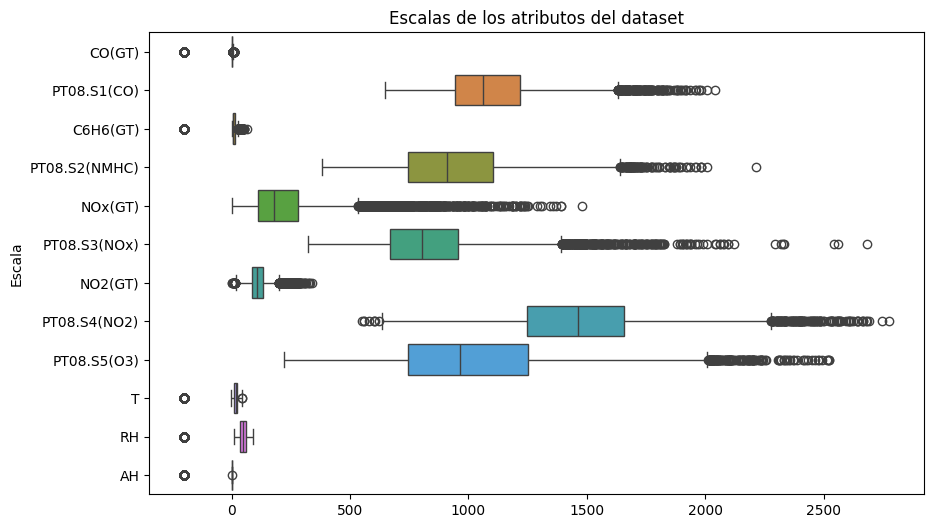

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, orient = 'h')
plt.title('Escalas de los atributos del dataset')
plt.ylabel('Escala')
plt.show()

En la imagen superior podemos ver la escala de los datos, y, aparte de tener una gran cantidad de outliers como decíamos previamente, la escala es muy dispar, por lo que tenemos que aplicar normalización. En nuestro caso vamos a eliminar los outliers extremos usando el método del rango intercuartílico (IQR), y tras eso aplicaremos normalización, en nuestro caso hemos elegido RobustScaler, ya que usa la mediana y el rango intercuartil en lugar de la media y desviación estándar, lo que lo hace más robusto.

<ipython-input-25-d438471d8c1e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])


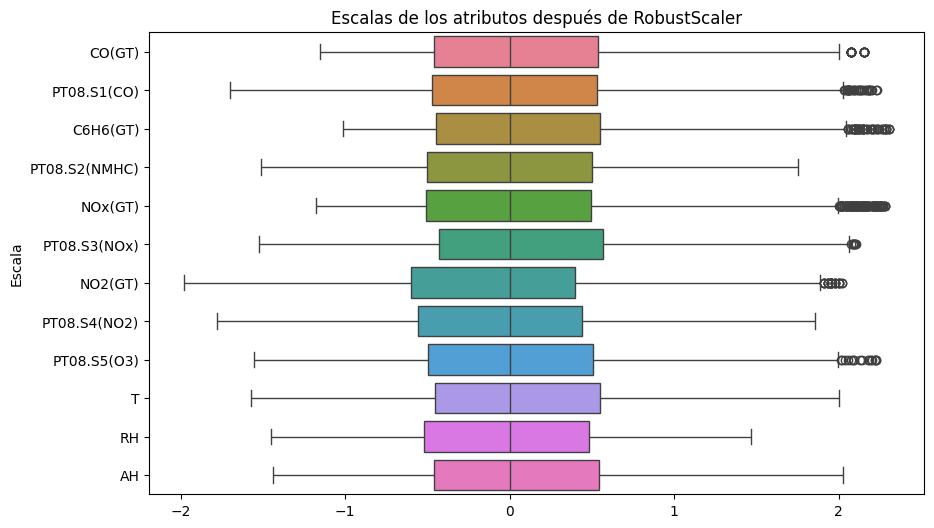

In [25]:
# Seleccionar solo las columnas numéricas
columnas_numericas = df.select_dtypes(include=["float64"]).columns

Q1 = df[columnas_numericas].quantile(0.25)
Q3 = df[columnas_numericas].quantile(0.75)
IQR = Q3 - Q1

# Filtrar valores dentro de 1.5*IQR
df = df[~((df[columnas_numericas] < (Q1 - 1.5 * IQR)) | (df[columnas_numericas] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Aplicar RobustScaler
scaler = RobustScaler()
df[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])

# Verificar con boxplot después de escalar

plt.figure(figsize=(10,6))
sns.boxplot(data=df[columnas_numericas], orient='h')
plt.title('Escalas de los atributos después de RobustScaler')
plt.ylabel('Escala')
plt.show()


El siguiente paso es estudiar correlación entre las variables, para ello vamos a hacer un plot de una matriz de correlación. Vamos a seguir el siguiente criterio:

- r > 0.7 o r < -0.7 → Fuerte correlación
- 0.5 < |r| < 0.7 → Correlación moderada
- |r| < 0.5 → Débil o sin correlación

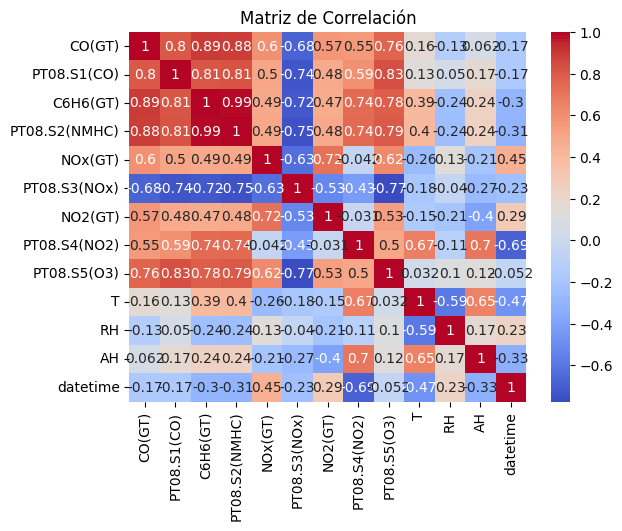

In [26]:
sns.heatmap(df.corr(),annot=True,cmap = 'coolwarm')
plt.title('Matriz de Correlación')
plt.show()

En la imagen, se observa lo siguiente:

- C6H6(GT) y PT08.S2(NMHC) tienen una correlación de ~0.99
- PT08.S5(O3) y PT08.S1(CO) tienen alta correlación (~0.85 - 0.9)
- CO(GT) y C6H6(GT) están altamente correlacionadas (~0.9)

Evidentemente hay más variables altamente correlacionadas, pero esas son las más notables.

Lo que vamos a hacer es eliminar C6H6 y CO (GT) por estar altamente correlacionadas entre sí y con la variable PT08.S2(NMHC) para evitar problemas de multicolinealidad.

In [27]:
# Eliminar variables redundantes
df = df.drop(columns=["C6H6(GT)", "CO(GT)"])

print(df.columns)

Index(['PT08.S1(CO)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)',
       'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'datetime'],
      dtype='object')


Por último lo que vamos a hacer es introducir nuevas características que puedan resultar interesantes. Los datos tienen un componente temporal importante, ya que todos los datos están modelados según un instante de tiempo que ahora tenemos definido con DateTime. Para poder aprovechar ese carácter secuencial de los datos lo que vamos a hacer es intruducir las siguientes variables: Hora del día, día de la semana, mes, día del año y semana del año. De esta manera eliminamos DateTime (ya que al no ser numerica no podemos usarla para entrenamiento) pero mantenemos información relativa al tiempo.

In [28]:
# Extraer características temporales del datetime
df["hour"] = df["datetime"].dt.hour  # Hora del día (0-23)
df["day_of_week"] = df["datetime"].dt.dayofweek  # Día de la semana (0=Monday, ..., 6=Sunday)
df["month"] = df["datetime"].dt.month  # Mes (1-12)
df["day_of_year"] = df["datetime"].dt.dayofyear  # Día del año (1-365)
df["week_of_year"] = df["datetime"].dt.isocalendar().week  # Semana del año

# Ahora podemos eliminar la columna datetime
df = df.drop(columns=["datetime"])

In [29]:
df.head()

,PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,day_of_week,month,day_of_year,week_of_year
0,1.438914,0.573883,-0.029412,0.919679,0.155556,0.574930,0.820388,-0.341270,0.035581,-0.403559,18,2,3,70,11
1,1.131222,0.261168,-0.492647,1.393574,-0.311111,0.278552,0.101942,-0.365079,-0.009363,-0.461907,19,2,3,70,11
2,1.628959,0.206186,-0.286765,1.257028,0.177778,0.269638,0.349515,-0.476190,0.226592,-0.417288,20,2,3,70,11
3,1.511312,0.237113,0.014706,1.064257,0.355556,0.334262,0.662621,-0.547619,0.451311,-0.351353,21,2,3,70,11
4,1.040724,-0.147766,-0.286765,1.518072,0.222222,0.124791,0.436893,-0.531746,0.436330,-0.347559,22,2,3,70,11


Llegados a este punto ya tenemos el dataset listo para empezar a experimentar con los entrenamientos de los modelos.

# **Entrenamiento de modelos de ML**

Para proceder con el entrenamiento hay que elegir una variable target, en nuestro caso hemos optado por el sensor PT08.S1(CO), ya que puede ser un buen indicador de la calidad del aire.

In [30]:
# Separar variables predictoras (X) y variable objetivo (Y)
y = df["PT08.S1(CO)"]
X = df.drop(columns=["PT08.S1(CO)"])  # Eliminamos la variable objetivo y datetime

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# División del dataset en 80% entrenamiento y 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Train Shape: (4705, 14), Test Shape: (1177, 14)


## XGBoost Regressor

Entrenamos un modelo XGBoost para regresión mediante el ajuste de hiperparámetros con validación cruzada de 3 pliegues. Como estamos en regresión, la métrica que nos indicará el mejor modelo es el coeficiente de determinación $R^2$, que indica qué tan bien un modelo de regresión explica la variabilidad de la variable objetivo en función de las variables independientes (features).

In [32]:
# Definir la cuadrícula de hiperparámetros específica para XGBoost
param_grid = {
    "n_estimators": [50, 75, 100],
    "max_depth": [5, 10, 15],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0]
}

# Crear el modelo base de XGBoost
xgb_model = XGBRegressor(random_state=SEED, objective="reg:squarederror")

# Configurar Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=3, scoring="r2", n_jobs=-1, verbose=2)

# Ajustar el modelo con Grid Search
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Obtener el mejor modelo
best_xgb = grid_search.best_estimator_

# Hacer predicciones con el mejor modelo
y_pred_best = best_xgb.predict(X_test)

# Evaluar métricas
print("\nXGBoost Optimizado")
print(f"R² Score: {r2_score(y_test, y_pred_best):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_best):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_best):.4f}")


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Mejores hiperparámetros encontrados:
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

XGBoost Optimizado
R² Score: 0.9709
MAE: 0.0979
MAPE: 1821490367576.3955


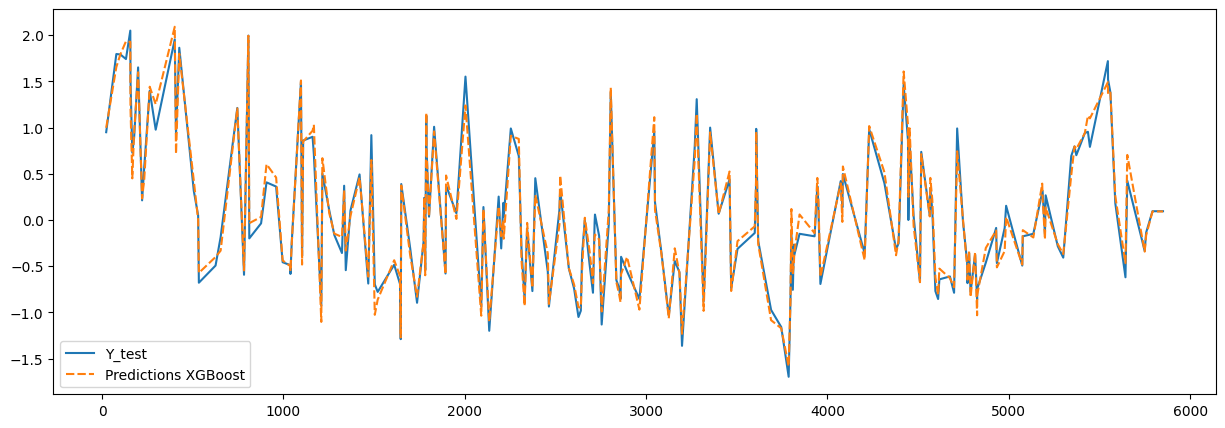

In [36]:
aux = pd.DataFrame()

aux['Y_test'] = y_test
aux['Predictions XGBoost'] = y_pred_best

plt.figure(figsize=(15,5))
sns.lineplot(data=aux.iloc[:200,:])
plt.show()

Podemos observar que el modelo `XGBoost` se adapta bastante bien en sus predicciones a la variable objetivo, aunque sí que es cierto que le cuesta un poco predecir los picos más abruptos. De todos modos el R2 score es de 0.98 y el MAE de 0.1, lo que indica un rendimiento excelente.

In [34]:
# Guardar el modelo entrenado
joblib.dump(best_xgb, "/content/MLEX-Practicas/training_models/xgboost_model.pkl")

['/content/MLEX-Practicas/training_models/xgboost_model.pkl']

# Métodos de ML explicativos

## LIME

Comenzamos utilizando el método LIME (Local Interpretable Model-Agnostic Explanations) para dar una exlicación local (es decir, de una única instancia) del funcionamiento de los modelos de caja negra que hemos entrenado en el apartado anterior.

### Crear el explicador LIME

In [35]:
# LIME explainer para datos tabulares
explainer = LimeTabularExplainer(X.values, #para generar el vecindario artificial
                                 feature_names=X.columns,
                                 class_names=["PT08.S1(CO)"], # la variable objetivo (target)
                                 mode = 'regression', #estamos en modo regresión
                                 random_state=SEED)

## Explicación local de una instancia

Seleccionamos una instancia aleatoria del dataset y daremos una epxlicación de la salida obtenida por los modelos de caja negra para esa instancia a través de un modelo sub-rogado, que será en este caso un modelo lineal Ridge (por defecto en LIME).

Definimos una función genérica, `local_explanation_lime`, para generar la explicación local. Esta función que recibe como argumentos:
- Indice en el dataset de la instancia a explicar.
- Modelo de caja negra.

In [37]:
def local_explanation_lime(index_instance: int, blackBoxModel, show = False):
    # Validar que el índice esté en el rango correcto
    assert 0 <= index_instance < X.shape[0], "Index out of bounds"

    # Generar la explicación para la instancia dada
    exp = explainer.explain_instance(
        X.loc[index_instance].values,  # Instancia a explicar
        blackBoxModel.predict,
        num_features=X.shape[1]  # Número de características a incluir en la explicación
    )

    # Mostrar la explicación en Jupyter Notebook
    if show:
        exp.show_in_notebook(show_all=False)

    # Obtener e imprimir los coeficientes de la explicación local
    explainer_list = exp.as_map()[1]
    explainer_list = sorted(explainer_list, key=lambda x: x[0])
    feature_importance = [x[1] for x in explainer_list]

    return feature_importance  # Opcionalmente, devolver la lista

In [43]:
# Cargar el modelo guardado en otro momento
model_xgboost = joblib.load("/content/MLEX-Practicas/training_models/xgboost_model.pkl")

In [49]:
# Fijar semilla y seleccionar un índice de instancia aleatorio
indice_aleatorio = X.sample(n=1, random_state=SEED).index[0]

In [50]:
#salida esperada:
y.loc[indice_aleatorio]

np.float64(-0.6787330316742081)

In [51]:
# Generar la explicación para esa instancia
lime_weights = pd.DataFrame(local_explanation_lime(indice_aleatorio, model_xgboost, show = True)).T

En la salida anterior, la barra central con dos campos: negative y positive; es la lista de características ordenadas por su influencia en la variable objetivo. Se utiliza el color azul para variables que disminuyen el valor de predicción (negative) y el color naranja para las features con un impacto positivo en el target (positive). La longitud de las barras de colores indica el impacto de la feature en la predicción y vemos como ese tamaño va disminuyendo conforme bajamos en la lista. Por tanto, concluímos que la variable que más impacto tiene en la predicción es `day_of_year`.

La tabla de abajo muestra el valor de las variables o features (marcadas en distinto color en base a su influencia en el target) en la instancia que se quiere explicar.

Podemos observar los coeficientes reales asignados a cada feature para esta instancia, o lo que es lo mismo, los valores de los coeficientes $\beta_i$ en el modelo de regresión lineal Ridge:

In [52]:
lime_weights.columns = X.columns
lime_weights

,PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,day_of_week,month,day_of_year,week_of_year
0,-0.081106,-0.016511,-0.144416,-0.062801,-0.084927,-0.204195,0.077509,-0.035918,0.186941,-0.010362,0.104976,-0.056546,-0.341632,-0.015867


## Interpretación de los resultados de LIME

Este análisis explica el impacto de cada variable en la predicción del sensor **PT08.S1 (CO)**. Los coeficientes obtenidos muestran qué características influyen más en la predicción del modelo.

---

## 🔹 Factores que MÁS REDUCEN la Predicción (`Impacto negativo`)
Estas variables tienen un **efecto negativo en la predicción**, es decir, a **mayores valores**, la predicción del sensor de CO tiende a disminuir.

| **Variable**          | **Peso LIME** | **Interpretación** |
|----------------------|--------------|----------------|
| **PT08.S5 (O3)**    | **-0.204195**   | Un mayor nivel de **ozono (O₃)** reduce la predicción del monóxido de carbono, lo que puede indicar una relación inversa entre estos contaminantes. |
| **PT08.S3 (NOx)**   | **-0.144416**   | Un aumento en la concentración de **óxidos de nitrógeno (NOx)** en este sensor reduce la predicción del CO, lo que puede estar asociado con diferentes fuentes de emisión. |
| **day_of_year**      | **-0.341632**   | La época del año influye en la concentración de CO. Durante ciertos periodos del año, los niveles de CO pueden disminuir debido a cambios estacionales. |


---

## 🔹 Factores que MÁS AUMENTAN la Predicción (`Impacto positivo`)
Estas variables tienen un **efecto positivo en la predicción**, es decir, a **mayores valores**, la predicción del sensor de CO tiende a aumentar.

| **Variable**       | **Peso LIME** | **Interpretación** |
|-------------------|--------------|----------------|
| **AH (Humedad absoluta)** | **+0.186941** | Un leve aumento en la humedad absoluta podría estar asociado con una mayor presencia de monóxido de carbono. |
| **day_of_week**         | **+0.104976**  | El día de la semana afecta la concentración de CO, posiblemente debido a patrones estacionales o meteorológicos, o a mayor concentración de vehículos los fines de semana. |


---

**Interpretación general:**
- Variables relacionadas con otros contaminantes del aire, como ozono (O₃) y óxidos de nitrógeno (NOx), tienen una influencia negativa sobre la predicción del CO. Esto sugiere posibles interacciones químicas o diferencias en las fuentes de emisión de estos compuestos.
- Las variables temporales como el día del año y el día de la semana también afectan significativamente la predicción, lo que indica que la estacionalidad y los patrones de actividad humana juegan un papel relevante en la presencia de CO en el ambiente.
- La humedad absoluta (AH) aparece como un factor que incrementa la predicción del CO, posiblemente debido a su relación con condiciones atmosféricas que favorecen la concentración de contaminantes.

---

**Explicación informal a un cliente**:

Cuando hay más ozono (O₃) y óxidos de nitrógeno (NOx) en el aire, parece que el sensor detecta menos CO. Quizás porque estos contaminantes provienen de fuentes diferentes o porque hay reacciones químicas en la atmósfera que los hacen disminuir juntos. También influye en qué época del año estamos. Si estamos en ciertas semanas del año o meses, parece que el CO baja. Esto tiene sentido, porque en invierno, por ejemplo, la gente usa más calefacción, y en verano los gases se dispersan más.

## Explicación global con LIME

Usamos el modelo local LIME para intentar dar una explicación global de las predicciones que está dando el modelo de caja negra, que en este caso es `XGBoost`.

Para ello, aplicaremos LIME a muchos ejemplos diferentes del dataset y guardaremos los pesos de las explicaciones individuales. Una vez hecho eso, podemos usar el promedio de los pesos obtenidos para cada feature con el objetivo de tener una idea de cómo están contribuyendo de manera global.

In [53]:
weights = []
for i in range(500):
    weights.append(local_explanation_lime(i, model_xgboost, show = False))

In [54]:
#Create DataFrame to manipulate the explanations.
lime_weights = pd.DataFrame(weights)
lime_weights.columns = X.columns
lime_weights.head()

,PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,day_of_week,month,day_of_year,week_of_year
0,0.210993,0.011845,-0.128647,0.035865,0.291137,0.493062,-0.026674,-0.002212,-0.074932,0.048811,-0.026633,0.078543,0.515492,0.005115
1,0.091008,-0.010347,-0.132194,0.022790,0.095917,0.028960,-0.044675,-0.014878,-0.169891,0.059521,-0.055587,0.081073,0.508264,-0.009213
2,0.074583,-0.005750,-0.113239,0.017097,0.078744,0.011079,-0.047902,0.023680,-0.066173,0.027476,-0.011331,0.066538,0.494788,0.014314
3,0.091880,0.018866,-0.107690,0.031648,0.068804,0.485393,-0.044349,-0.001725,-0.067204,0.045647,-0.046882,0.063455,0.485237,0.005410
4,-0.068449,0.005077,-0.163313,0.031347,0.080199,0.024976,-0.043673,-0.017690,-0.060545,0.034710,-0.025846,0.073733,0.519282,0.011944


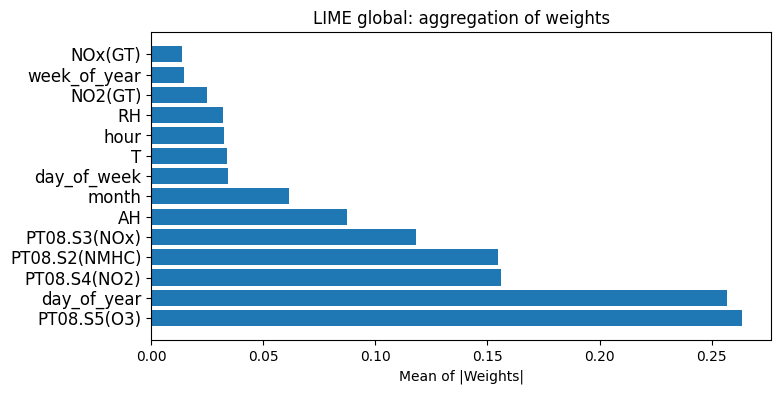

In [55]:
# compute absolute mean
abs_mean = lime_weights.abs().mean()

#dataframe with 2 columns: feature name and absolute mean
abs_mean = pd.DataFrame(data = {'feature':abs_mean.index, 'abs_mean':abs_mean})
abs_mean = abs_mean.sort_values(by='abs_mean', ascending=False)
abs_mean.head()

# SHOW IN A BAR PLOT
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,4))
y_ticks = range(len(abs_mean))
y_labels = abs_mean.feature

plt.barh(y = y_ticks, width = abs_mean.abs_mean)
plt.yticks(ticks = y_ticks, labels = y_labels, size = 12)
plt.title('LIME global: aggregation of weights')
plt.ylabel('')
plt.xlabel('Mean of |Weights|')
plt.show()

### Interpretación del gráfico: Importancia global de las variables según LIME (modelo XGBoost)

Este gráfico muestra el promedio de los pesos absolutos asignados por **LIME** a cada variable, tras analizar 500 instancias del modelo **XGBoost**. Esta medida refleja **cuánto influye, en promedio, cada variable en las predicciones individuales del modelo**.

#### Variables más influyentes:
- **PT08.S5(O3)** (sensor de ozono) y **day_of_year** (día del año) son claramente las **dos variables más influyentes**, con un impacto medio muy superior al resto. Esto indica que:
  - Las predicciones del modelo dependen fuertemente de los niveles de **ozono**.
  - El **componente estacional o calendario** tiene gran relevancia, posiblemente porque la concentración de contaminantes varía con la época del año.

- Le siguen **PT08.S4(NO2)** y **PT08.S2(NMHC)** (sensores de dióxido de nitrógeno y compuestos orgánicos no metánicos), que también presentan una influencia destacada, lo que sugiere que hay una **relación importante entre estos contaminantes y el objetivo del modelo**.

#### Variables con influencia intermedia:
- **PT08.S3(NOx)** (óxidos de nitrógeno) y **AH** (humedad absoluta) tienen un impacto moderado.
- Variables como **month**, **day_of_week**, **T** (temperatura), y **hour** (hora del día) tienen peso bajo, pero no despreciable.

---

### Conclusión
El modelo XGBoost basa sus decisiones principalmente en las lecturas de **sensores químicos (O₃, NO₂, NMHC)** y en **variables temporales**, especialmente el **día del año**. Esto concuerda con un comportamiento estacional de los contaminantes atmosféricos y sugiere que el modelo está capturando patrones ambientales y temporales reales.


## SHAP

In [56]:
import shap
explainer = shap.Explainer(model_xgboost)

In [57]:
shap_values = explainer(X_test)

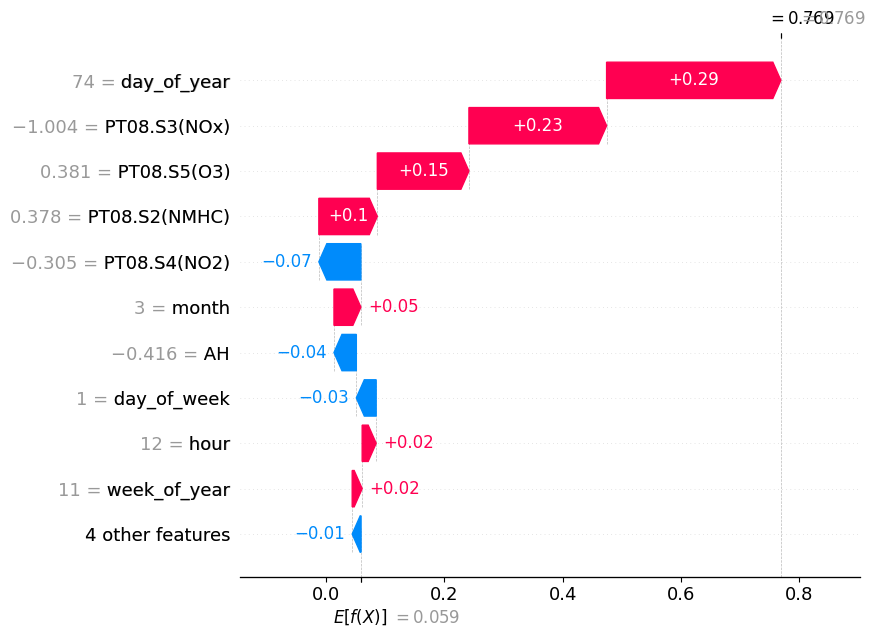

In [58]:
shap.plots.waterfall(shap_values[0], max_display=11)

### Interpretación de la gráfica Waterfall de SHAP

La gráfica *waterfall* de SHAP muestra cómo cada característica contribuye a la predicción de un registro específico con respecto a un valor base (la media de las predicciones, en este caso `E[f(X)] = 0.069`).

1. **Eje horizontal:** representa la escala de la predicción.  
2. **Predicción final:** se alcanza el valor `f(x) = -0.933` al aplicar las contribuciones (valores SHAP) de cada característica a la media.  
3. **Barras negativas (azules) y positivas (rojas):** indican si cada característica reduce (desplazamiento a la izquierda) o aumenta (desplazamiento a la derecha) el valor final.  
4. **Etiquetas de valor:** el texto a la izquierda (por ejemplo, `-0.589 = PT08.S5(O3)`) corresponde al valor real de la característica; el valor sobre la barra (por ejemplo, `-0.41`) indica la magnitud de su efecto sobre la predicción.  

En este ejemplo, la variable `PT08.S5(O3)` se asocia con la mayor contribución negativa (`-0.41`), seguida por `PT08.S2(NMHC)`, `day_of_year`, `PT08.S3(NOx)`, entre otras, que continúan disminuyendo el valor estimado con respecto a la media. El resultado de la suma de todas las aportaciones es la predicción final `f(x) = -0.933`.



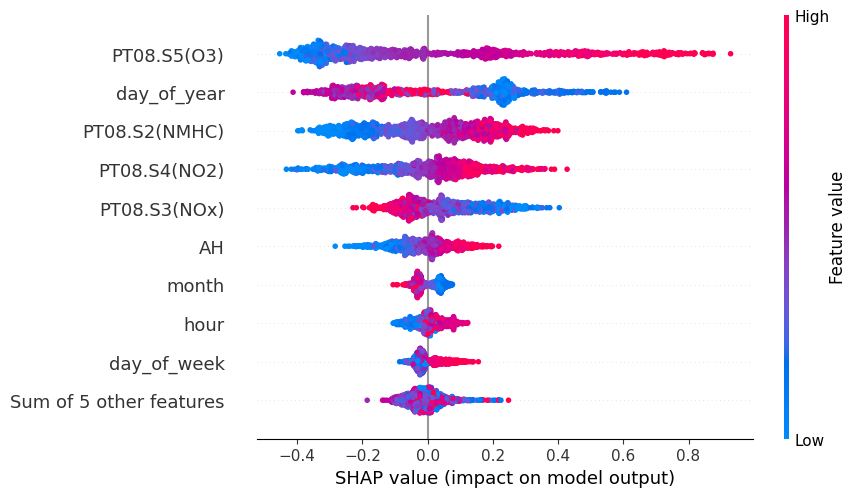

In [59]:
shap.plots.beeswarm(shap_values)

### Interpretación de la gráfica Beeswarm de SHAP

La gráfica *beeswarm* ordena las características por su **importancia general** (amplitud de valores SHAP) y muestra la **distribución** de sus efectos en cada instancia del conjunto de datos.

- **Eje X (SHAP value):** indica el impacto de la característica sobre la predicción. Valores positivos desplazan la salida del modelo hacia arriba; valores negativos la desplazan hacia abajo.
- **Colores (alto vs. bajo):** cada punto representa una muestra. El color señala el valor real de esa característica (rojo para valores más altos, azul para valores más bajos).
- **Amplitud y dispersión:** cuanto mayor es la extensión horizontal de los puntos para una característica, mayor es la variabilidad de su impacto en el modelo. Una característica con puntos muy dispersos a izquierda y derecha posee un efecto más diverso (y, por tanto, una mayor importancia media).

En el ejemplo, se aprecia que `PT08.S5(O3)` y `PT08.S2(NMHC)` presentan el rango de valores SHAP más amplio, lo cual indica una contribución significativa en la predicción de `PT08.S1(CO)`. El color de los puntos (rojo/azul) revela cómo valores altos o bajos de cada sensor/variable tienden a empujar la salida del modelo en un sentido u otro.


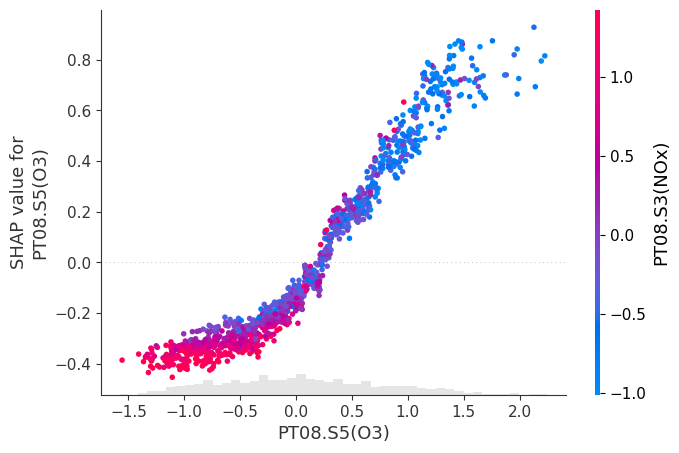

In [60]:
shap.plots.scatter(shap_values[:,"PT08.S5(O3)"], color=shap_values)

### Interpretación de la gráfica Scatter de SHAP

Este diagrama *scatter* relaciona los valores de la variable `PT08.S5(O3)` (eje X) con su correspondiente valor SHAP (eje Y), mostrando cómo cambios en la característica influyen en la predicción. El color de los puntos (según la barra a la derecha) representa el valor de otra variable —en este caso, `PT08.S3(NOx)`— lo que permite observar posibles interacciones.

1. **Eje X (Valor de `PT08.S5(O3)`):** muestra la medida real del sensor `PT08.S5(O3)` en cada instancia.
2. **Eje Y (Valor SHAP de `PT08.S5(O3)`):** indica en qué medida esa variable desplaza la salida del modelo por encima (valores positivos) o por debajo (valores negativos) de la predicción base.
3. **Color (Valor de `PT08.S3(NOx)`):** la gradación de colores (azul/rojo) añade una tercera dimensión, revelando posibles sinergias o efectos combinados de `PT08.S5(O3)` y `PT08.S3(NOx)` sobre la predicción.
4. **Curva de tendencia:** se aprecia cómo, a medida que aumenta el valor de `PT08.S5(O3)`, el valor SHAP tiende a pasar de negativo a positivo (o viceversa). Esto indica el punto aproximado en que esta característica empieza a incrementar la salida del modelo en lugar de disminuirla.

En conjunto, la gráfica permite identificar patrones no lineales y la interacción entre `PT08.S5(O3)` y `PT08.S3(NOx)`, brindando una visión más profunda de cómo las lecturas de estos dos sensores influyen conjuntamente en la estimación de la variable objetivo.
